# ECGNet Experimentation

**Useful papers (original Stanford paper):**

https://arxiv.org/pdf/1707.01836.pdf

https://github.com/awni/ecg/

**Other useful links:**

[ResNet Shape Matching Tips](https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33)

[PyTorch Time Series Forecasting](https://github.com/jdb78/pytorch-forecasting)

[Choice of categorical vs sparse cat. cross entropy](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other)

[Sliding window procedure tips](https://datascience.stackexchange.com/questions/29173/time-series-forecasting-sliding-window-method)

In [1]:
%set_env TF_FORCE_GPU_ALLOW_GROWTH=true
import pandas as pd
import numpy as np
import os
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses
from sklearn.preprocessing import Normalizer, OneHotEncoder, StandardScaler
import imblearn

from matplotlib.pyplot import plot

env: TF_FORCE_GPU_ALLOW_GROWTH=true


## Helper Functions

In [2]:
def preprocess_dataframe(df):
    
    '''
        Reads & preprocess dataframe w/ 3 labels: time, signal, label
    '''
    
    #df = df.iloc[:, 1:] # use system time - keep for DenoisedNormalizedData set
    df.columns = ['time','signal_val','label'] # set labels
    df = df.loc[df.time.notnull()].copy() # getting only not null values
    #df.time = (df.time * 1000).astype('int') #- keep for DenoisedNormalizedData set
    
    df = df.iloc[1:,:] # removes first row of labels
    
    df["label"] = df["label"].astype('str').astype('int')
    df["time"] = df["time"].astype('str').astype('int')
    df["signal_val"] = df["signal_val"].astype('str').astype('double')
    #df.label = df.label.astype('int') # labels as int - keep for DenoisedNormalizedData set
    
    return df

In [3]:
def import_train_test_data(data_dir, test_user=None):
    
    '''
        See here for more info:
        https://github.com/atabas/Heartbeat-Classification/blob/master/ImageConversion.ipynb
    '''
    
    train = pd.DataFrame([], columns=['time', 'signal_val', 'label'])    # train dataset
    test = pd.DataFrame([], columns=['time', 'signal_val', 'label'])     # test dataset
    
    for filename in os.listdir(data_dir):
        if filename.endswith('.csv'):
            
            df = pd.read_csv(data_dir + '/' + filename, header=None)
            df = preprocess_dataframe(df)

            user_num = int(re.findall(r'\d+',filename.split('_')[0])[0]) #get user number

            # Ignore first 2 rows/samples in each (garbage data)    
            if (user_num != test_user):
                train = train.append(df.iloc[2:])
            else:
                test = test.append(df.iloc[2:])

    return train, test

In [4]:
from math import floor

def time_series_splicing(data, window_size=224):
    
    '''
       Create dataset from time-snippets of window_size length 
        Any extra samples are discarded (no overlap; *wasteful*)
    '''
    
    # Dropping time column as not needed
    data = data.drop(columns=['time'])
    num_samples = floor(data.shape[0] / window_size)
    
    print('Total # of samples of window_size = {}: {}'. format(window_size, num_samples))
    
    result = np.empty(shape=(num_samples, window_size, 2))
    
    start = 0;
    
    for i in range(num_samples):
        
        # splice original dataframe into window_size chunks
        result[i,:,:] = data.iloc[start : start + window_size, :]
        start = start + window_size
    
    print('Splicing done; {} original entries discarded'.format(data.shape[0] - start))
    
    return result

In [5]:
def create_overlap_window(df, window=256, overlap=0.5):
    '''
        TODO: NOT COMPLETED AT ALL YET
        Creates a new dataset based on sliding window across the
        given dataset. Shape of the dataset is [# of window samples, shape of original set]
        overlap: % of overlap between windows
    '''
    limit = df.shape[0] - window
    arr = df.to_numpy(dtype=np.float)
    start_idx = 0
    end_idx = window
    
    new_dims = [1, window, arr.shape[-1]]     # shape of new dataset
    new_set = np.empty(new_dims)              # holding array for new samples
    
    for i in trange(0, limit):
#         print('appending range {} - {}'.format(start_idx, end_idOverlapx))
        
        # save the sample
        new_set = np.append(new_set, np.expand_dims(arr[start_idx:end_idx], axis=0), axis=0)
        
        # update index
        start_idx += 1
        end_idx += 1

    return new_set

In [6]:
def print_class_distribution(train_labels, test_labels):
    # Training class distribution
    lb, lbl = np.unique(train_labels, return_counts=True)
    if (len(lbl) < 3):
        print('Training set has less that 3 classes!')
        print(lb)
        print(lbl)
    else:
        lbl_sum = np.sum(lbl)
        lbl = [100*count/lbl_sum for count in lbl]
        print('Training class distribution: c0={:.2f}%, c1={:.2f}%, c2={:.2f}%'.format(lbl[0], lbl[1], lbl[2]))
        print(lbl)
    
    
    # Test class distribution
    lb, lbl = np.unique(test_labels, return_counts=True)
    if (len(lbl) < 3):
        print('Test set has less that 3 labels!')
        print(lb)
        print(lbl)
    else:
        lbl_sum = np.sum(lbl)
        lbl = [100*count/lbl_sum for count in lbl]
        print('\nTesting class distribution: c0={:.2f}%, c1={:.2f}%, c2={:.2f}%'.format(lbl[0], lbl[1], lbl[2]))
        print(lbl)

In [67]:
def preprocess_categorical(data, check_class_dist=False):
    '''
        Process sample labeling to categorical major label (per sample)
    '''
    samples = data[:,:,0]
    labels = np.empty(shape=(data.shape[0],), dtype='int')
    
    for i in range(data.shape[0]):
        label0 = np.count_nonzero(data[i,:,1] == 0)
        label1 = np.count_nonzero(data[i,:,1] == 1)
        label2 = np.count_nonzero(data[i,:,1] == 2)
    
        occurence = [label0, label1, label2]
        
        # major class labeling
        major_label = occurence.index(max(occurence))
        labels[i] = major_label

    if not check_class_dist:        
        # to categorical using one-hot
        labels = keras.utils.to_categorical(labels, num_classes=3)
    
    return samples, labels

# Data Import

In [8]:
train_set, test_set = import_train_test_data('IRRlabeldata_3c',test_user=3)
# train_set,_ = import_train_test_data('IRRlabeldata_3c') # using entire training set

test_set.head()

,time,signal_val,label
3,597953,3.590046,0
4,597957,0.936436,0
5,597960,-0.089901,0
6,597964,-0.956960,0
7,597968,-0.947791,0


In [9]:
test_set.shape

(46011, 3)

# Data exploration

In [10]:
# Class distribution on original dataset (476388 training, 46389 test); test user #2
# Training: c0 - 17.7%; c1 - 21.5%, c2 - 60.8%
# Testing:  c0 - 16.6%; c1 - 22.1%; c2 - 61.4%0
print_class_distribution(train_set['label'], test_set['label'])

Training class distribution: c0=17.72%, c1=21.48%, c2=60.81%
[17.71551308243803, 21.478942665486443, 60.80554425207553]

Testing class distribution: c0=16.69%, c1=22.26%, c2=61.06%
[16.68731390319706, 22.25554758644672, 61.05713851035622]


**Notes:**
- Test set 6 has only label c0 (class 0) with 7678 samples
 - With window splicing (3 seconds), only 8 test samples!
- User 9 has 66% of class 2 (~ 6% higher than usual)
- User 11 has c2 of 57% (~4% lower than usual)
 - With splicing, getting ~22-23-55 class distribution


**Typical distribution (stays consistant with window splicing)**:
<!-- 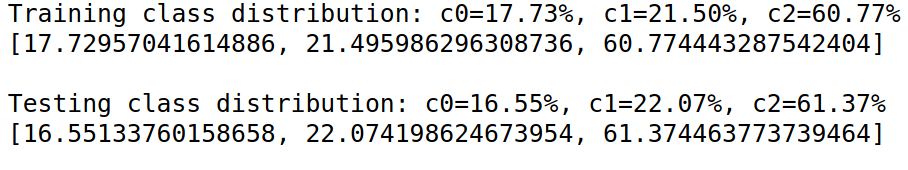 -->
<div>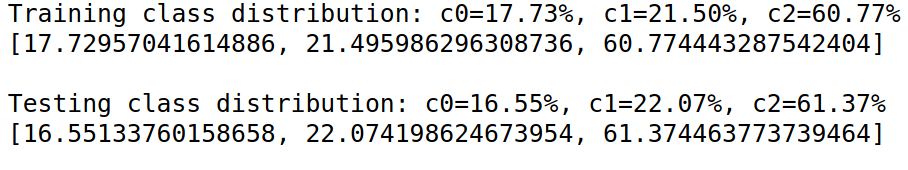</div>
<!-- ![image.png](attachment:image.png) -->

In [68]:
# Check class distribution after majority labeling w/ every test user & window size
#
# ==== RESULTS per window size =====
#  1280 => 2 classes
#  720  => 2 classes (for usr 6, only 1 class)
#  2560 => 2 classes

win_size = 720

for i in [2,3,4,5,6,8,9,11,12,13,14,16]:
    
    print('Original class distribution for test_user = {}'.format(i))
    train, test = import_train_test_data('IRRlabeldata_3c',test_user=i)
    print_class_distribution(train['label'], test['label'])
    
    print('\nProcessed majority-class distribution for test_user = {}'.format(i))

    train = time_series_splicing(train, win_size)
    test = time_series_splicing(test, win_size)
    x_tr, y_tr = preprocess_categorical(train, check_class_dist=True)
    x_te, y_te = preprocess_categorical(test, check_class_dist=True)
    print_class_distribution(y_tr, y_te)
    
    print('\n===================================\n')

Original class distribution for test_user = 2
Training class distribution: c0=17.73%, c1=21.50%, c2=60.77%
[17.72957041614886, 21.495986296308736, 60.774443287542404]

Testing class distribution: c0=16.55%, c1=22.07%, c2=61.37%
[16.55133760158658, 22.074198624673954, 61.374463773739464]

Processed majority-class distribution for test_user = 2
Total # of samples of window_size = 720: 661
Splicing done; 448 original entries discarded
Total # of samples of window_size = 720: 64
Splicing done; 309 original entries discarded
Training class distribution: c0=17.70%, c1=21.63%, c2=60.67%
[17.700453857791224, 21.6338880484115, 60.665658093797276]

Testing class distribution: c0=17.19%, c1=21.88%, c2=60.94%
[17.1875, 21.875, 60.9375]


Original class distribution for test_user = 3
Training class distribution: c0=17.72%, c1=21.48%, c2=60.81%
[17.71551308243803, 21.478942665486443, 60.80554425207553]

Testing class distribution: c0=16.69%, c1=22.26%, c2=61.06%
[16.68731390319706, 22.25554758644672

Training class distribution: c0=17.73%, c1=21.49%, c2=60.78%
[17.726965523320978, 21.49282802799105, 60.78020644868797]

Testing class distribution: c0=16.58%, c1=22.11%, c2=61.32%
[16.576350957490448, 22.107558453334484, 61.31609058917507]

Processed majority-class distribution for test_user = 16
Total # of samples of window_size = 720: 661
Splicing done; 518 original entries discarded
Total # of samples of window_size = 720: 64
Splicing done; 239 original entries discarded
Training class distribution: c0=17.55%, c1=21.79%, c2=60.67%
[17.549167927382754, 21.78517397881997, 60.665658093797276]

Testing class distribution: c0=17.19%, c1=21.88%, c2=60.94%
[17.1875, 21.875, 60.9375]




# Data preprocessing

(476746,)


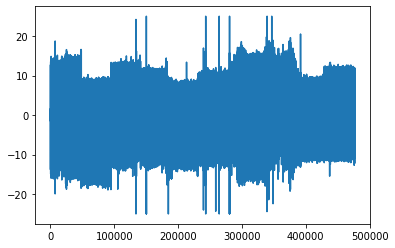

In [58]:
# ===== Max Normalization ======
# Max normalization (fit on only train set, transform both train and test)
l1_normalizer = Normalizer(norm='max').fit(train_set['signal_val'].to_numpy().reshape(1,-1))
t= train_set['signal_val'].to_numpy().reshape(1,-1)
t.shape

plot(t[0,:])
print(train_set['signal_val'].shape)
# transform signal_val for both train and test set
# train_set['signal_val'] = l2_normalizer.transform(train_set['signal_val'])
# test_set['signal_val'] = l2_normalizer.transform(test_set['signal_val'])

z = l1_normalizer.transform(train_set['signal_val'].to_numpy().reshape(1,-1))
c = l1_normalizer.transform(test_set['signal_val'].to_numpy().reshape(1,-1))

(476746,)


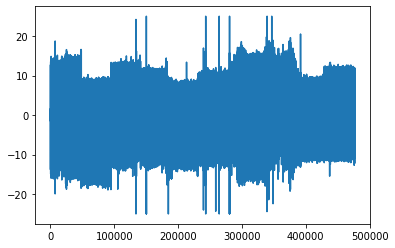

In [79]:
# ===== L1 Normalization ======
# L1 normalization (fit on only train set, transform both train and test)
l1_normalizer = Normalizer(norm='l1').fit(train_set['signal_val'].to_numpy().reshape(1,-1))
t= train_set['signal_val'].to_numpy().reshape(1,-1)
t.shape

plot(t[0,:])
print(train_set['signal_val'].shape)
# transform signal_val for both train and test set
# train_set['signal_val'] = l2_normalizer.transform(train_set['signal_val'])
# test_set['signal_val'] = l2_normalizer.transform(test_set['signal_val'])

z = l1_normalizer.transform(train_set['signal_val'].to_numpy().reshape(1,-1))
c = l1_normalizer.transform(test_set['signal_val'].to_numpy().reshape(1,-1))

(476746,)


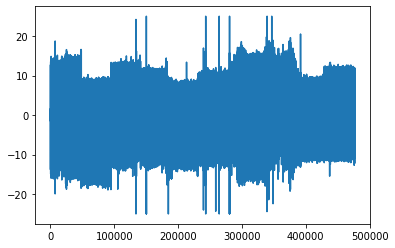

In [26]:
# ===== L2 Normalization =====
# L2 normalization (fit on only train set, transform both train and test)
l2_normalizer = Normalizer(norm='l2').fit(train_set['signal_val'].to_numpy().reshape(1,-1))
t= train_set['signal_val'].to_numpy().reshape(1,-1)
t.shape

plot(t[0,:])
print(train_set['signal_val'].shape)
# transform signal_val for both train and test set
# train_set['signal_val'] = l2_normalizer.transform(train_set['signal_val'])
# test_set['signal_val'] = l2_normalizer.transform(test_set['signal_val'])

z = l2_normalizer.transform(train_set['signal_val'].to_numpy().reshape(1,-1))
c = l2_normalizer.transform(test_set['signal_val'].to_numpy().reshape(1,-1))

In [59]:
# Apply normalization
train_set['signal_val'] = z[0,:]
test_set['signal_val'] = c[0,:]

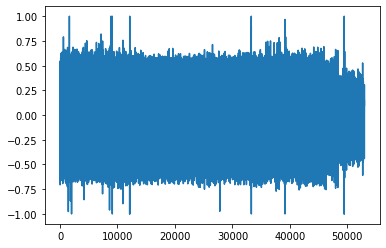

In [60]:
plot(train_set['signal_val'])

## Time series splicing

In [13]:
# OLD info: 294 = 1s 1468 = 5 seconds, before: 224 samples per 1 sample
# Sample frequency: 256 Hz => 256 = 1s, 1280 = 5s, 2560 = 10s
ts_window_size = 1280 

train_set = time_series_splicing(train_set, ts_window_size)
test_set = time_series_splicing(test_set, ts_window_size)

Total # of samples of window_size = 1280: 372
Splicing done; 586 original entries discarded
Total # of samples of window_size = 1280: 35
Splicing done; 1211 original entries discarded


In [32]:
x_train, y_train = preprocess_categorical(train_set)

In [47]:
x_test, y_test = preprocess_categorical(test_set)

In [62]:
# check if majority labeling changed class distribution
# NOTE: needs change in preprocess_categorical() to remove keras.to_categorical()
# print_class_distribution(y_train, y_test)

Training set has ess that 3 labels!
[0. 1.]
[740 370]
Test set has ess that 3 labels!
[0. 1.]
[74 37]


In [64]:
# To fit in the model (some issues with dimensions)
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)

## Visualization (sanity check)

In [33]:
x_train.shape

(408, 1280)

In [65]:
y_train.shape

(372, 1, 3)

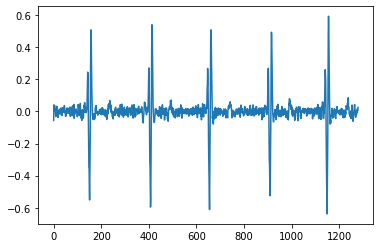

In [49]:
plot(x_train[0])

In [60]:
y_train[9].shape

(1, 3)

In [39]:
np.unique(y_train, return_counts=True)

(array([0., 1.], dtype=float32), array([372, 186]))

# ECGNet (Balamurali 2018)

#### _Model (original from [paper](https://ieeexplore.ieee.org/document/8438739)):_
**Input:** 720 samples

**Output:** 3 classes

**Loss:** cross-entropy

**Training:** SGD, LR=0.01, momentum=0.9, minibatch=8, epochs=50

**Residual blocks:** 64*k conv filters, where k = 1 and increased every 4th res block

##### ECGNet Architecture
https://ieeexplore.ieee.org/document/8438739

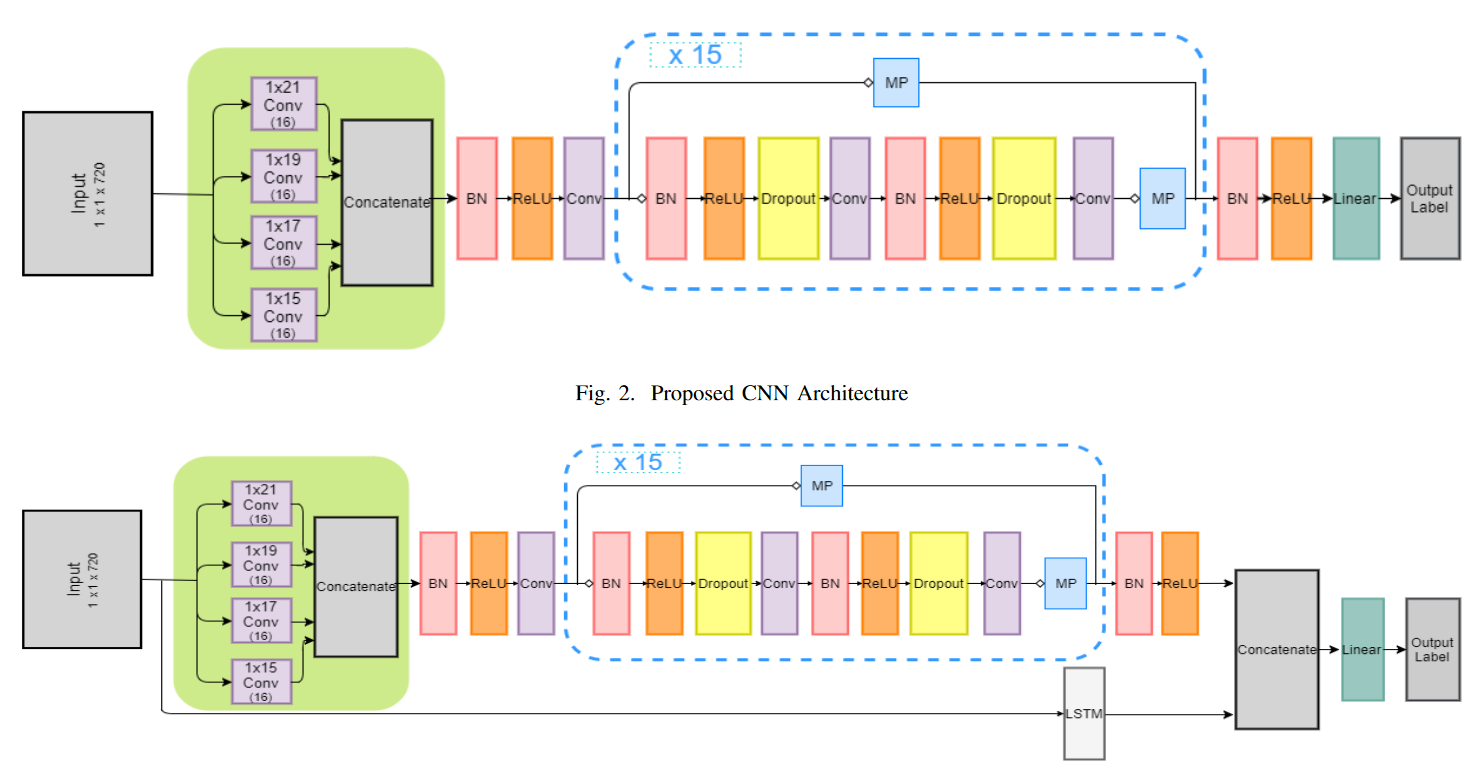

In [34]:
def _resBlock(input_layer, n_filters, dropout_rate=0.2):
    
    # Convolutional path
    bn1 = layers.BatchNormalization()(input_layer)
    relu1 = layers.ReLU()(bn1)
    drop1 = layers.Dropout(rate=dropout_rate)(relu1)
    conv1 = layers.Conv1D(filters=n_filters, kernel_size=17, padding='same')(drop1)
    
    bn2 = layers.BatchNormalization()(conv1)
    relu2 = layers.ReLU()(bn2)
    drop2 = layers.Dropout(rate=dropout_rate)(relu2)
    conv2 = layers.Conv1D(filters=n_filters, kernel_size=17, padding='same')(drop2)
    mp = layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(conv2)
    
    # Residual path
    shortcut = layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(input_layer)
    
    # Combining the two paths (adding)
    print("shortcut shape: " +str(shortcut.shape))
    print("mp shape: " +str(mp.shape))
    
    # If shortcut filters don't match, match them with Conv1D of 1x1 kernel
    if (shortcut.shape[2] != mp.shape[2]):
        shortcut = layers.Conv1D(filters=mp.shape[2], kernel_size=1)(shortcut)
        
    output = layers.Add()([shortcut, mp])
    
    return output

In [67]:
def ecgnet(input_shape=(720,1), output_shape=(3,), with_lstm=True):
    
    input_layer = layers.Input(shape=input_shape)
    
    # ======= RNN (LSTM) =======
    # TO CHECK: 12 timesteps each having 60 samples; output vector of size 40
    if with_lstm:
        lstm = layers.LSTM(units=40)(input_layer) 
    
    # ======= Residual Conv Net =======
    # Head: 4 parallel convolutional layers
    conv1 = layers.Conv1D(filters=16, kernel_size=21)(input_layer)
    conv2 = layers.Conv1D(filters=16, kernel_size=19)(input_layer)
    conv3 = layers.Conv1D(filters=16, kernel_size=17)(input_layer)
    conv4 = layers.Conv1D(filters=16, kernel_size=15)(input_layer)
    
    # concatenate 4 conv layers
    concat1 = layers.Concatenate(axis=1)([conv1, conv2, conv3, conv4]) # which axis?
    
    bn1 = layers.BatchNormalization()(concat1)
    relu1 = layers.ReLU()(bn1)
    resBlockInput = layers.Conv1D(filters=32, kernel_size=17)(relu1) # idk num filters or kernel size
    
    # Residual blocks (15)
    k = 1 # multiplier for number of Conv1D filters
    resBlockOutput = resBlockInput
    for i in range(1,16):
        print('..adding resnet block #' + str(i))
        # increase K for every 4th block
        if (i in [4, 8, 12]):
            k += 1
            
        resBlockOutput = _resBlock(resBlockOutput, 64*k)
    
    # BN + ReLU after residual blocks
    bn3 = layers.BatchNormalization()(resBlockOutput)
    relu3 = layers.ReLU()(bn3)
    
    # ======== Concatenate LSTM with Residual Net ======
    if with_lstm:
        lstm = layers.Reshape((1,40), input_shape=lstm.shape)(lstm) # add dimension to match during concat; result: [None, 1, 40]
        concat2 = layers.Concatenate(axis=2)([relu3, lstm])
    else:
        concat2 = relu3
    
    # ======== Dense Net ==========
    output_layer = layers.Dense(output_shape[0])(concat2)
    output_layer = layers.Softmax()(output_layer)  # *** From Stanford paper
    
    # ==== Create and compile model ====
    # Use SparseCatCrossEntr. to keep labels as integers (not one-hot)
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    SGD = optimizers.SGD(learning_rate=0.01, momentum=0.9)
    
    model.compile(optimizer=SGD,
                  loss=losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model

In [68]:
ecgnet = ecgnet(input_shape=(ts_window_size,1), output_shape=(3,1), with_lstm=False)

..adding resnet block #1
shortcut shape: (None, 2518, 32)
mp shape: (None, 2518, 64)
..adding resnet block #2
shortcut shape: (None, 1259, 64)
mp shape: (None, 1259, 64)
..adding resnet block #3
shortcut shape: (None, 630, 64)
mp shape: (None, 630, 64)
..adding resnet block #4
shortcut shape: (None, 315, 64)
mp shape: (None, 315, 128)
..adding resnet block #5
shortcut shape: (None, 158, 128)
mp shape: (None, 158, 128)
..adding resnet block #6
shortcut shape: (None, 79, 128)
mp shape: (None, 79, 128)
..adding resnet block #7
shortcut shape: (None, 40, 128)
mp shape: (None, 40, 128)
..adding resnet block #8
shortcut shape: (None, 20, 128)
mp shape: (None, 20, 192)
..adding resnet block #9
shortcut shape: (None, 10, 192)
mp shape: (None, 10, 192)
..adding resnet block #10
shortcut shape: (None, 5, 192)
mp shape: (None, 5, 192)
..adding resnet block #11
shortcut shape: (None, 3, 192)
mp shape: (None, 3, 192)
..adding resnet block #12
shortcut shape: (None, 2, 192)
mp shape: (None, 2, 256)


In [22]:
# Model summary
ecgnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 720, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 700, 16)      352         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 702, 16)      320         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 704, 16)      288         input_1[0][0]                    
______________________________________________________________________________________________

In [71]:
# Save model as hdf5
# ecgnet.save('models/ecgnet.h5')

# Training & Experiments

### Experiments


**Normalization:** None, L1, L2, Max norm, Z-score (?)

**Model parameters:** ECGNet w/ and w/o LSTM, LR=0.01, momentum=0.9, 3-class one-hot labels

**Data:** depends; non-overlap windows; test-user=3

**Training parameters:** 40 epochs, 10% validation, 8 minibatch

ECGNet + LSTM (10s/5s/2.81s non-overlap windows):
- [X] No normalization
- [X] L1
- [X] L2 
- [X] MinMax
- [ ] Z-Score

ECGNet w/o LSTM (10s/5s/2.81s non-overlap windows):
- [X] No normalization
- [X] L1
- [X] L2 
- [X] MinMax
- [ ] Z-Score

**TODO:**
- Training & validation on all users (no LOSO test set)
- Validation with LOSO
 - Check whether Keras Model.fit validation uses K-Fold (?)
- Fix majority labeling (only ever has class 0 and 1)
 - SMOTE oversampling
- Ensemble learning (one for each LOSO test user)
- MIT BIH transfer learning

In [37]:
# TensorBoard callback if needed
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./tensorboard_logs")

In [38]:
# check if GPU is available, should return true
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [20]:
# ECGNet 10 epoch run, 20% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# L2 normalization of signal_val (fit on train set)
# Window slicing on 3 seconds (882 samples per window)
# Output: 3 class one-hot encoded
#
# Results: saturated at ~60% accuracy on training, 62.96% on validation
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=10, validation_split=0.2)

Epoch 1/10
54/54 [==============================] - 34s 631ms/step - loss: 1.0592 - accuracy: 0.5370 - val_loss: 30.1196 - val_accuracy: 0.6296
Epoch 2/10
54/54 [==============================] - 2s 43ms/step - loss: 0.9887 - accuracy: 0.5880 - val_loss: 27.0323 - val_accuracy: 0.6296
Epoch 3/10
54/54 [==============================] - 2s 42ms/step - loss: 0.9884 - accuracy: 0.6134 - val_loss: 1.6581 - val_accuracy: 0.2130
Epoch 4/10
54/54 [==============================] - 2s 42ms/step - loss: 0.9721 - accuracy: 0.6065 - val_loss: 3.6784 - val_accuracy: 0.2130
Epoch 5/10
54/54 [==============================] - 2s 43ms/step - loss: 0.9631 - accuracy: 0.6111 - val_loss: 1.3311 - val_accuracy: 0.2130
Epoch 6/10
54/54 [==============================] - 2s 43ms/step - loss: 0.9509 - accuracy: 0.5995 - val_loss: 1.5046 - val_accuracy: 0.6296
Epoch 7/10
54/54 [==============================] - 2s 42ms/step - loss: 0.9817 - accuracy: 0.6042 - val_loss: 1.0291 - val_accuracy: 0.6296
Epoch 8/1

In [53]:
# ECGNet 10 epoch run, 20% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# L2 normalization of signal_val (fit on train set)
# Window slicing on *10* seconds (2560 samples per window)
# Output: 3 class one-hot encoded
#
# Results: saturated at ~60% accuracy on training, 63.16% on validation
#          random jumps to 0.2105 on validation set from time to time
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=10, validation_split=0.1)

Epoch 1/10
21/21 [==============================] - 44s 2s/step - loss: 1.0214 - accuracy: 0.5689 - val_loss: 1706.5931 - val_accuracy: 0.6316
Epoch 2/10
21/21 [==============================] - 1s 51ms/step - loss: 0.9702 - accuracy: 0.6048 - val_loss: 0.9390 - val_accuracy: 0.6316
Epoch 3/10
21/21 [==============================] - 1s 49ms/step - loss: 0.9470 - accuracy: 0.6048 - val_loss: 0.9122 - val_accuracy: 0.6316
Epoch 4/10
21/21 [==============================] - 1s 48ms/step - loss: 0.9453 - accuracy: 0.6048 - val_loss: 0.9112 - val_accuracy: 0.6316
Epoch 5/10
21/21 [==============================] - 1s 48ms/step - loss: 0.9460 - accuracy: 0.6048 - val_loss: 0.9134 - val_accuracy: 0.6316
Epoch 6/10
21/21 [==============================] - 1s 52ms/step - loss: 0.9474 - accuracy: 0.6048 - val_loss: 0.9112 - val_accuracy: 0.6316
Epoch 7/10
21/21 [==============================] - 1s 49ms/step - loss: 0.9460 - accuracy: 0.6048 - val_loss: 0.9102 - val_accuracy: 0.6316
Epoch 8/10


### Test - 10s non-overlap., no normalization
ECGNet w/ LSTM; 10s non-overlap. window; 10% val split; test_usr=3; 10 epochs; mini_batch=8; **NO data normalization**

#### 10 epoch training:

<!-- 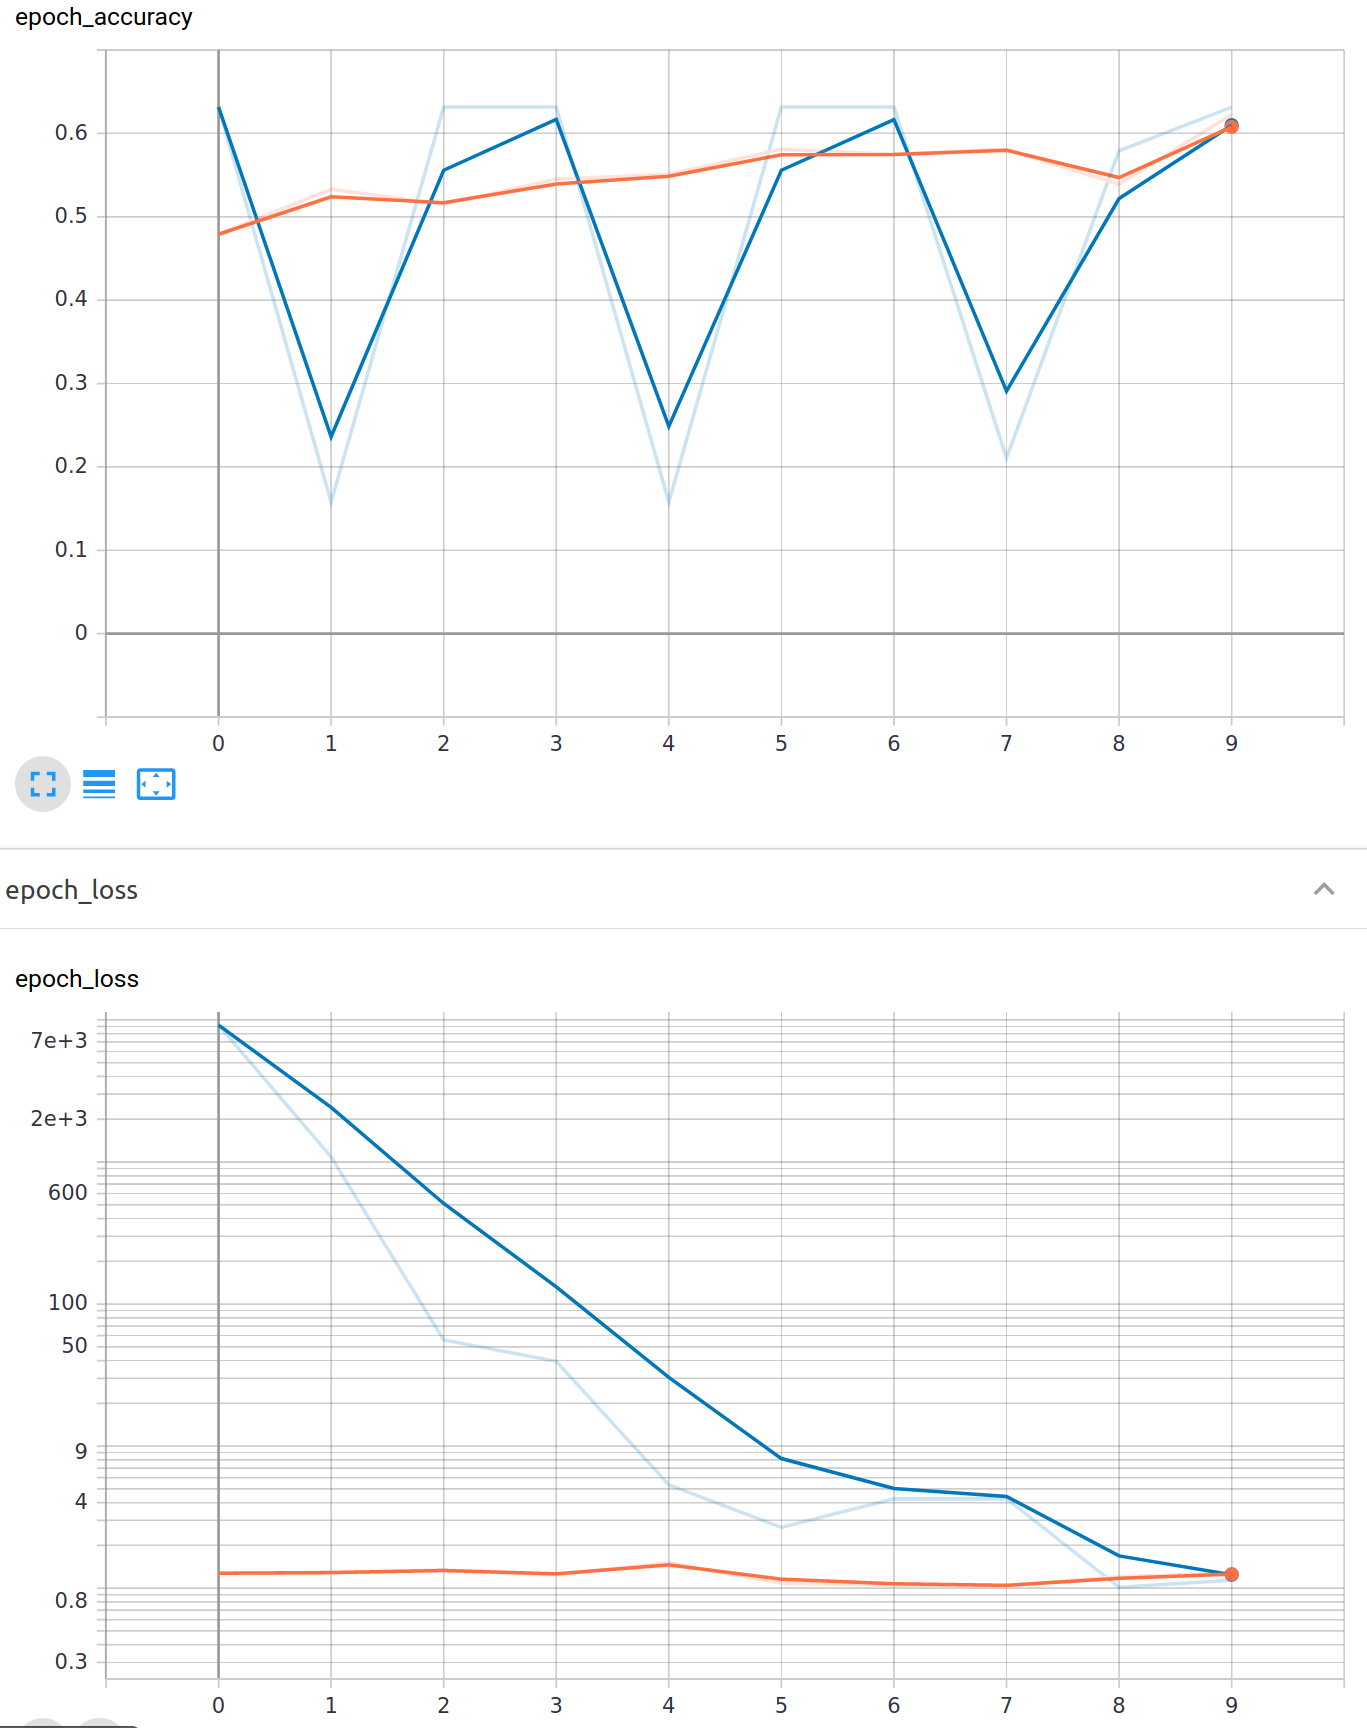 -->
<div>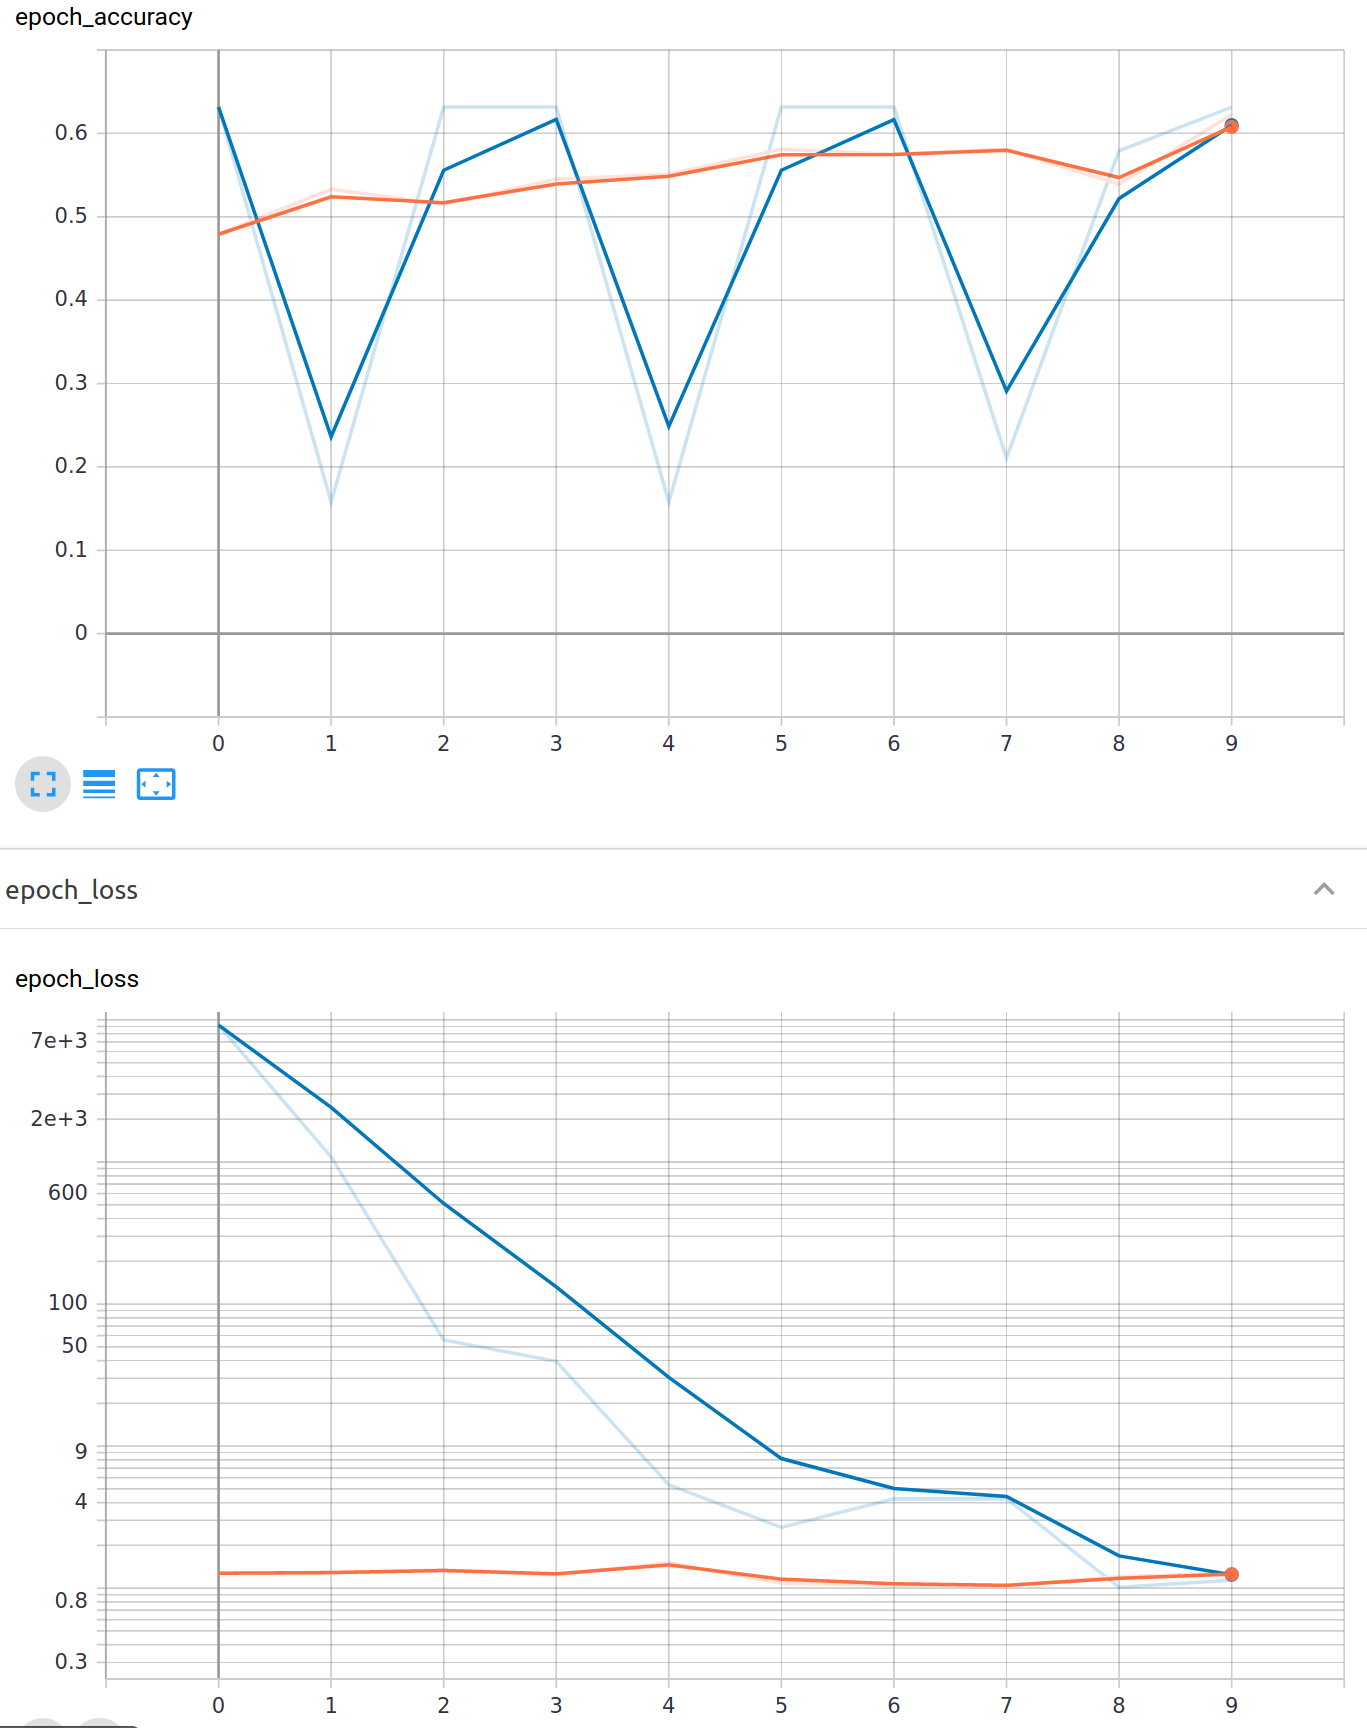</div>
<!-- 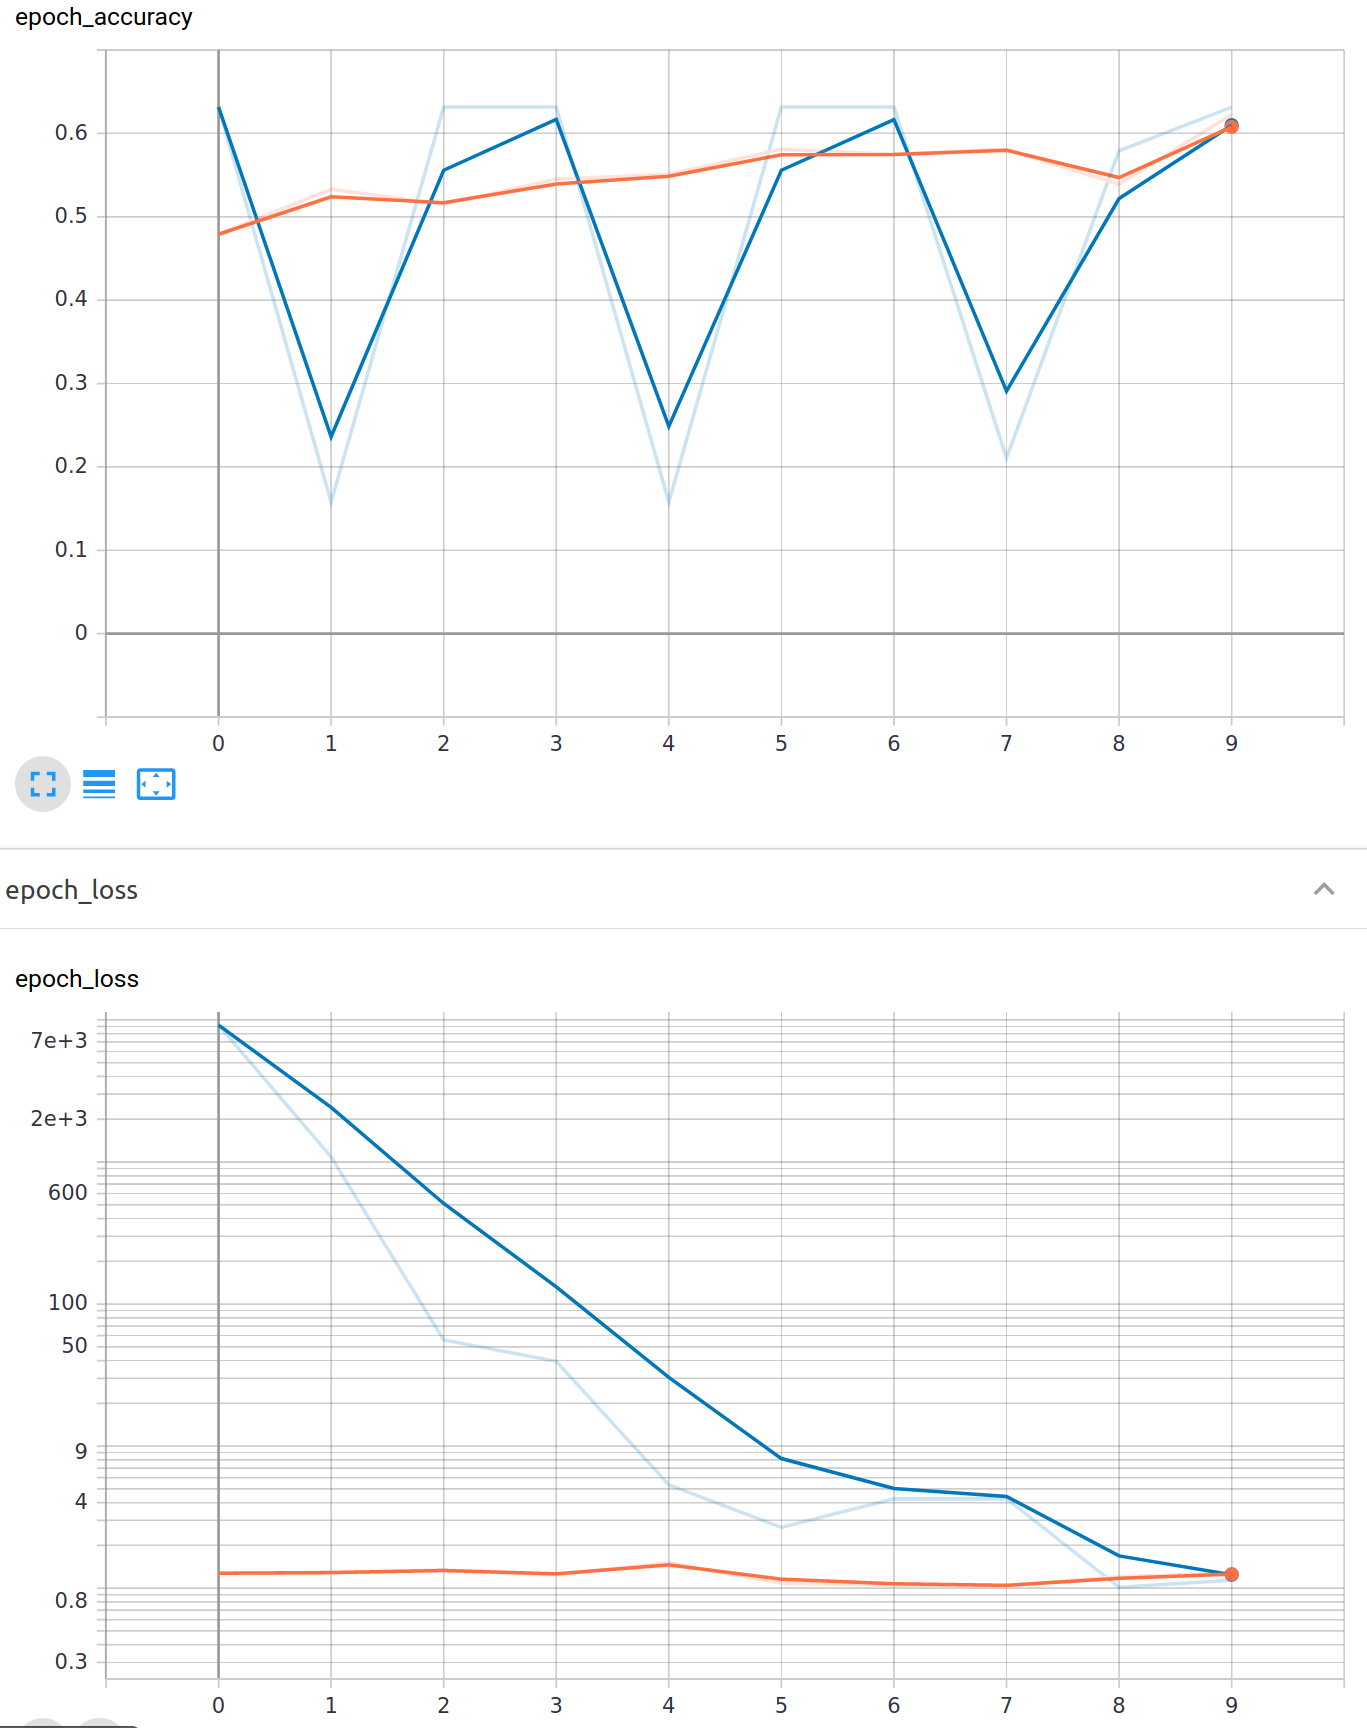 -->
<!-- 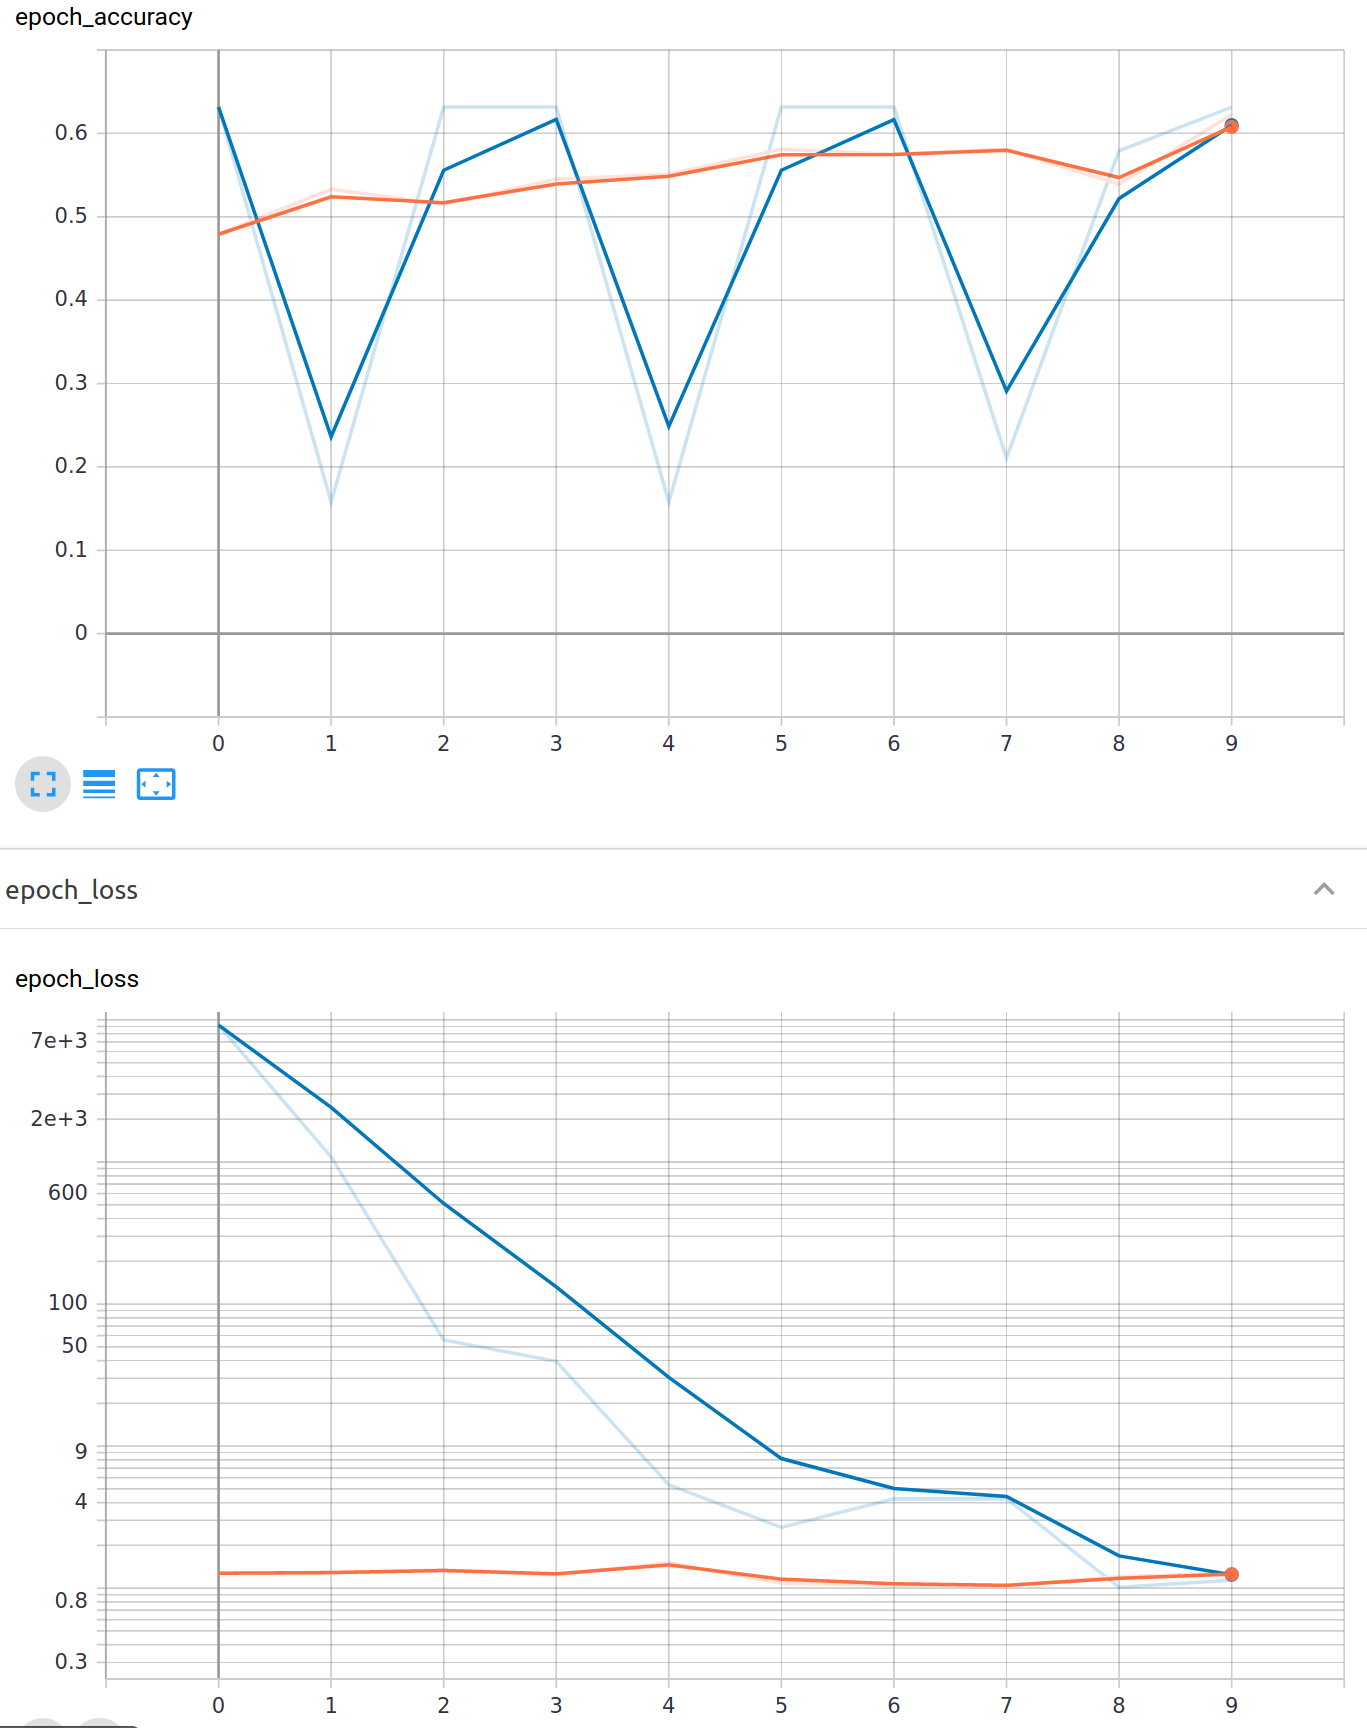 -->

#### 30 epoch training:
<!-- 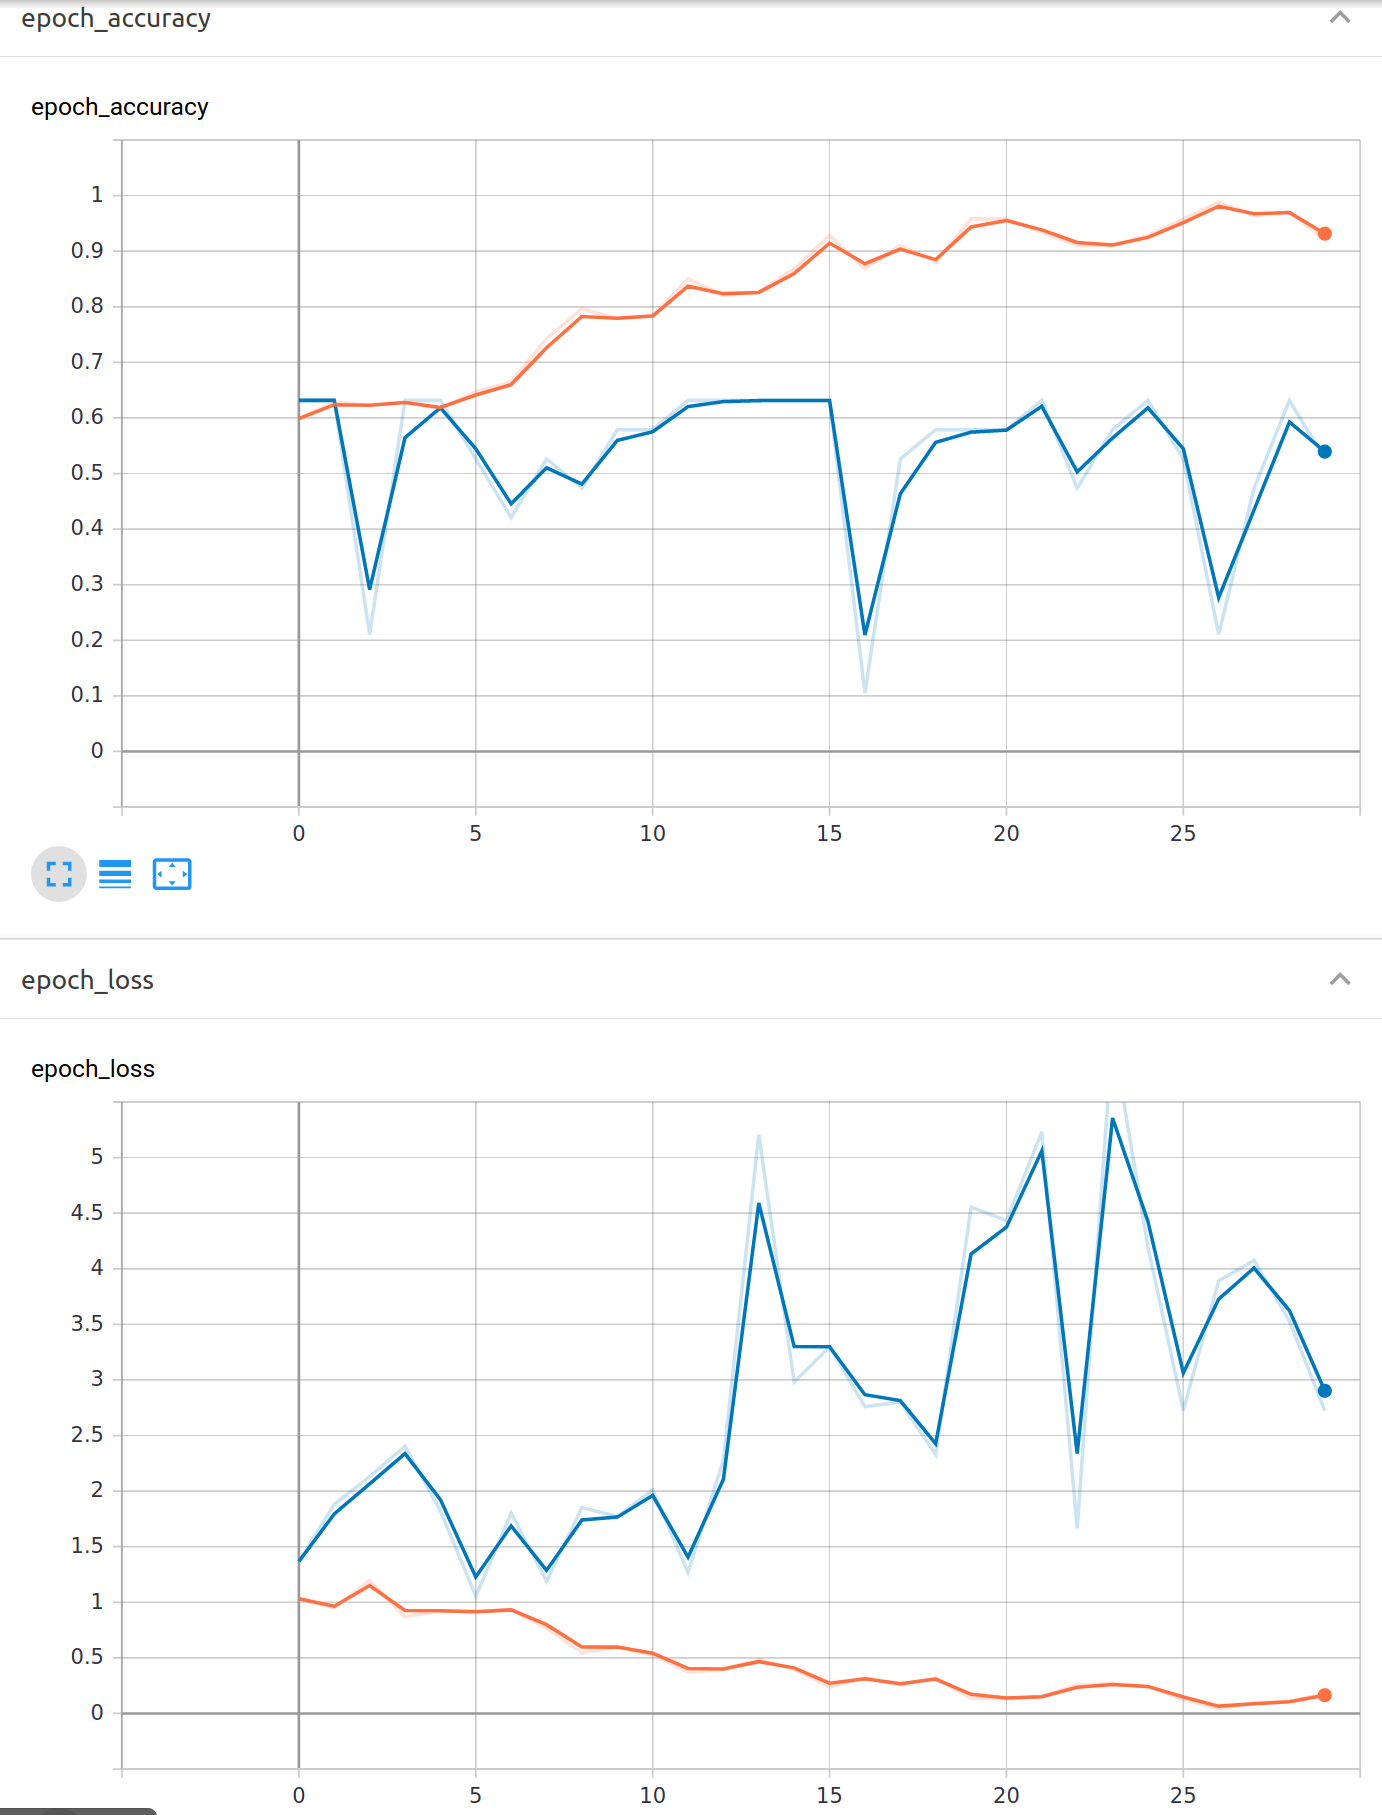 -->
<div>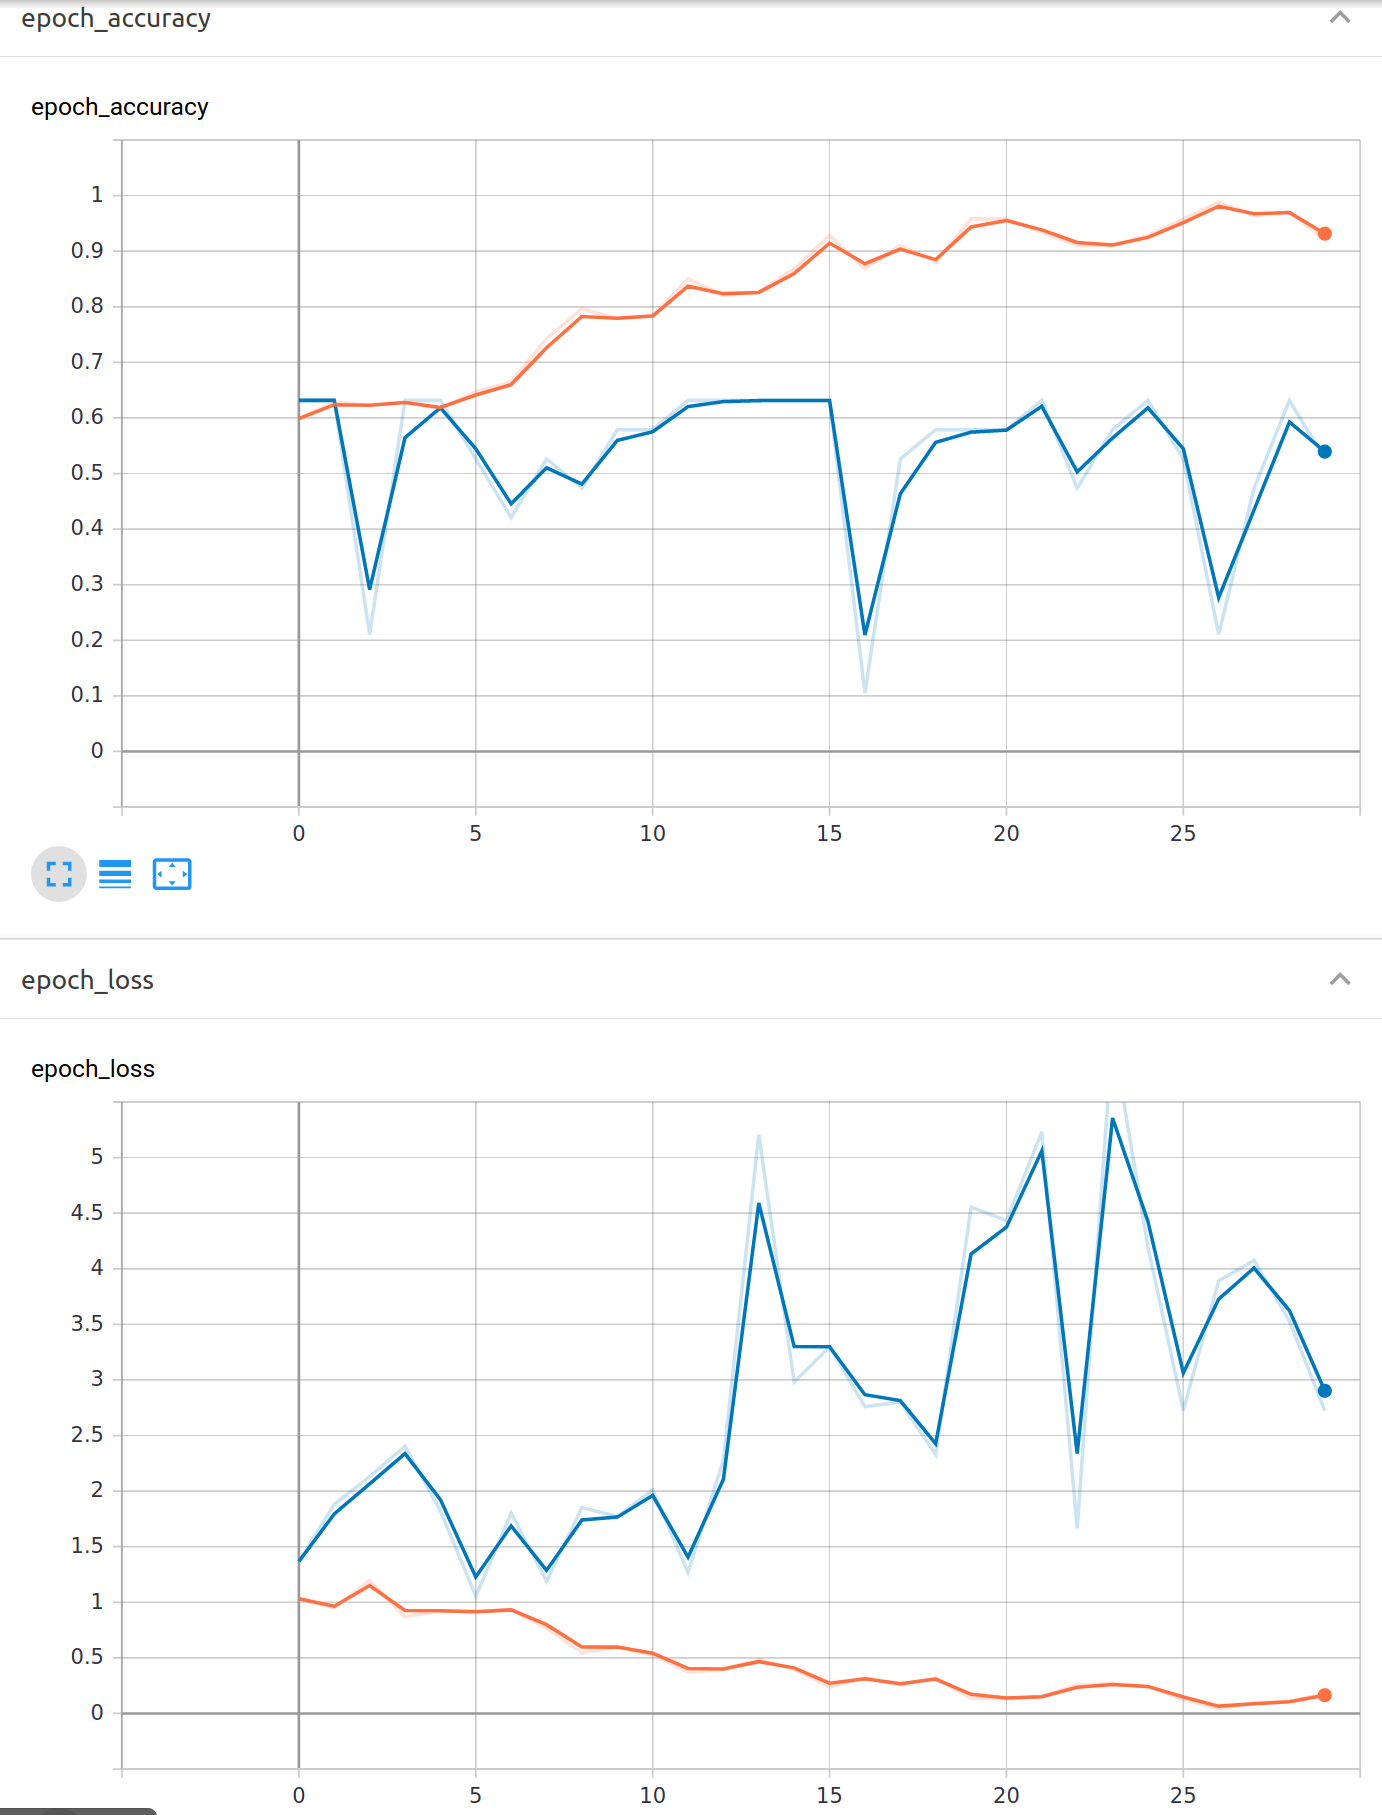</div>

In [106]:
# ECGNet 10 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# NO normalization of signal_val (fit on train set)
# Window slicing on *10* seconds (2560 samples per window)
# Output: 3 class one-hot encoded
#
# Results: saturated at ~60% accuracy on training, 63.16% on validation
#          random jumps to 0.2105 on validation set from time to time
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=10, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/10
21/21 [==============================] - 4s 175ms/step - loss: 1.2730 - accuracy: 0.4790 - val_loss: 9206.2139 - val_accuracy: 0.6316
Epoch 2/10
21/21 [==============================] - 2s 99ms/step - loss: 1.2892 - accuracy: 0.5329 - val_loss: 1085.4180 - val_accuracy: 0.1579
Epoch 3/10
21/21 [==============================] - 2s 101ms/step - loss: 1.3407 - accuracy: 0.5150 - val_loss: 55.8752 - val_accuracy: 0.6316
Epoch 4/10
21/21 [==============================] - 2s 106ms/step - loss: 1.2431 - accuracy: 0.5449 - val_loss: 39.5531 - val_accuracy: 0.6316
Epoch 5/10
21/21 [==============================] - 2s 100ms/step - loss: 1.5064 - accuracy: 0.5509 - val_loss: 5.3349 - val_accuracy: 0.1579
Epoch 6/10
21/21 [==============================] - 2s 102ms/step - loss: 1.0817 - accuracy: 0.5808 - val_loss: 2.6733 - val_accuracy: 0.6316
Epoch 7/10
21/21 [==============================] - 2s 105ms/step - loss: 1.0529 - accuracy: 0.5749 - val_loss: 4.2496 - val_accuracy: 0.6316

In [107]:
# ECGNet 10 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# NO normalization of signal_val (fit on train set)
# Window slicing on *10* seconds (2560 samples per window)
# Output: 3 class one-hot encoded
#
# Results: saturated at ~60% accuracy on training, 63.16% on validation
#          random jumps to 0.2105 on validation set from time to time
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=30, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/30
21/21 [==============================] - 2s 108ms/step - loss: 1.0326 - accuracy: 0.5988 - val_loss: 1.3666 - val_accuracy: 0.6316
Epoch 2/30
21/21 [==============================] - 2s 102ms/step - loss: 0.9510 - accuracy: 0.6287 - val_loss: 1.8802 - val_accuracy: 0.6316
Epoch 3/30
21/21 [==============================] - 2s 100ms/step - loss: 1.1945 - accuracy: 0.6228 - val_loss: 2.1299 - val_accuracy: 0.2105
Epoch 4/30
21/21 [==============================] - 2s 105ms/step - loss: 0.8707 - accuracy: 0.6287 - val_loss: 2.4033 - val_accuracy: 0.6316
Epoch 5/30
21/21 [==============================] - 2s 100ms/step - loss: 0.9235 - accuracy: 0.6168 - val_loss: 1.8216 - val_accuracy: 0.6316
Epoch 6/30
21/21 [==============================] - 2s 103ms/step - loss: 0.9138 - accuracy: 0.6467 - val_loss: 1.0553 - val_accuracy: 0.5263
Epoch 7/30
21/21 [==============================] - 2s 100ms/step - loss: 0.9356 - accuracy: 0.6647 - val_loss: 1.8010 - val_accuracy: 0.4211
Epoch 

## Test - 10s non-overlap., L2 normalization
ECGNet w/ LSTM; 10s non-overlap. window; 10% val split; test_usr=3; mini_batch=8; **L2 data normalization**

#### 40 epoch training:
<div>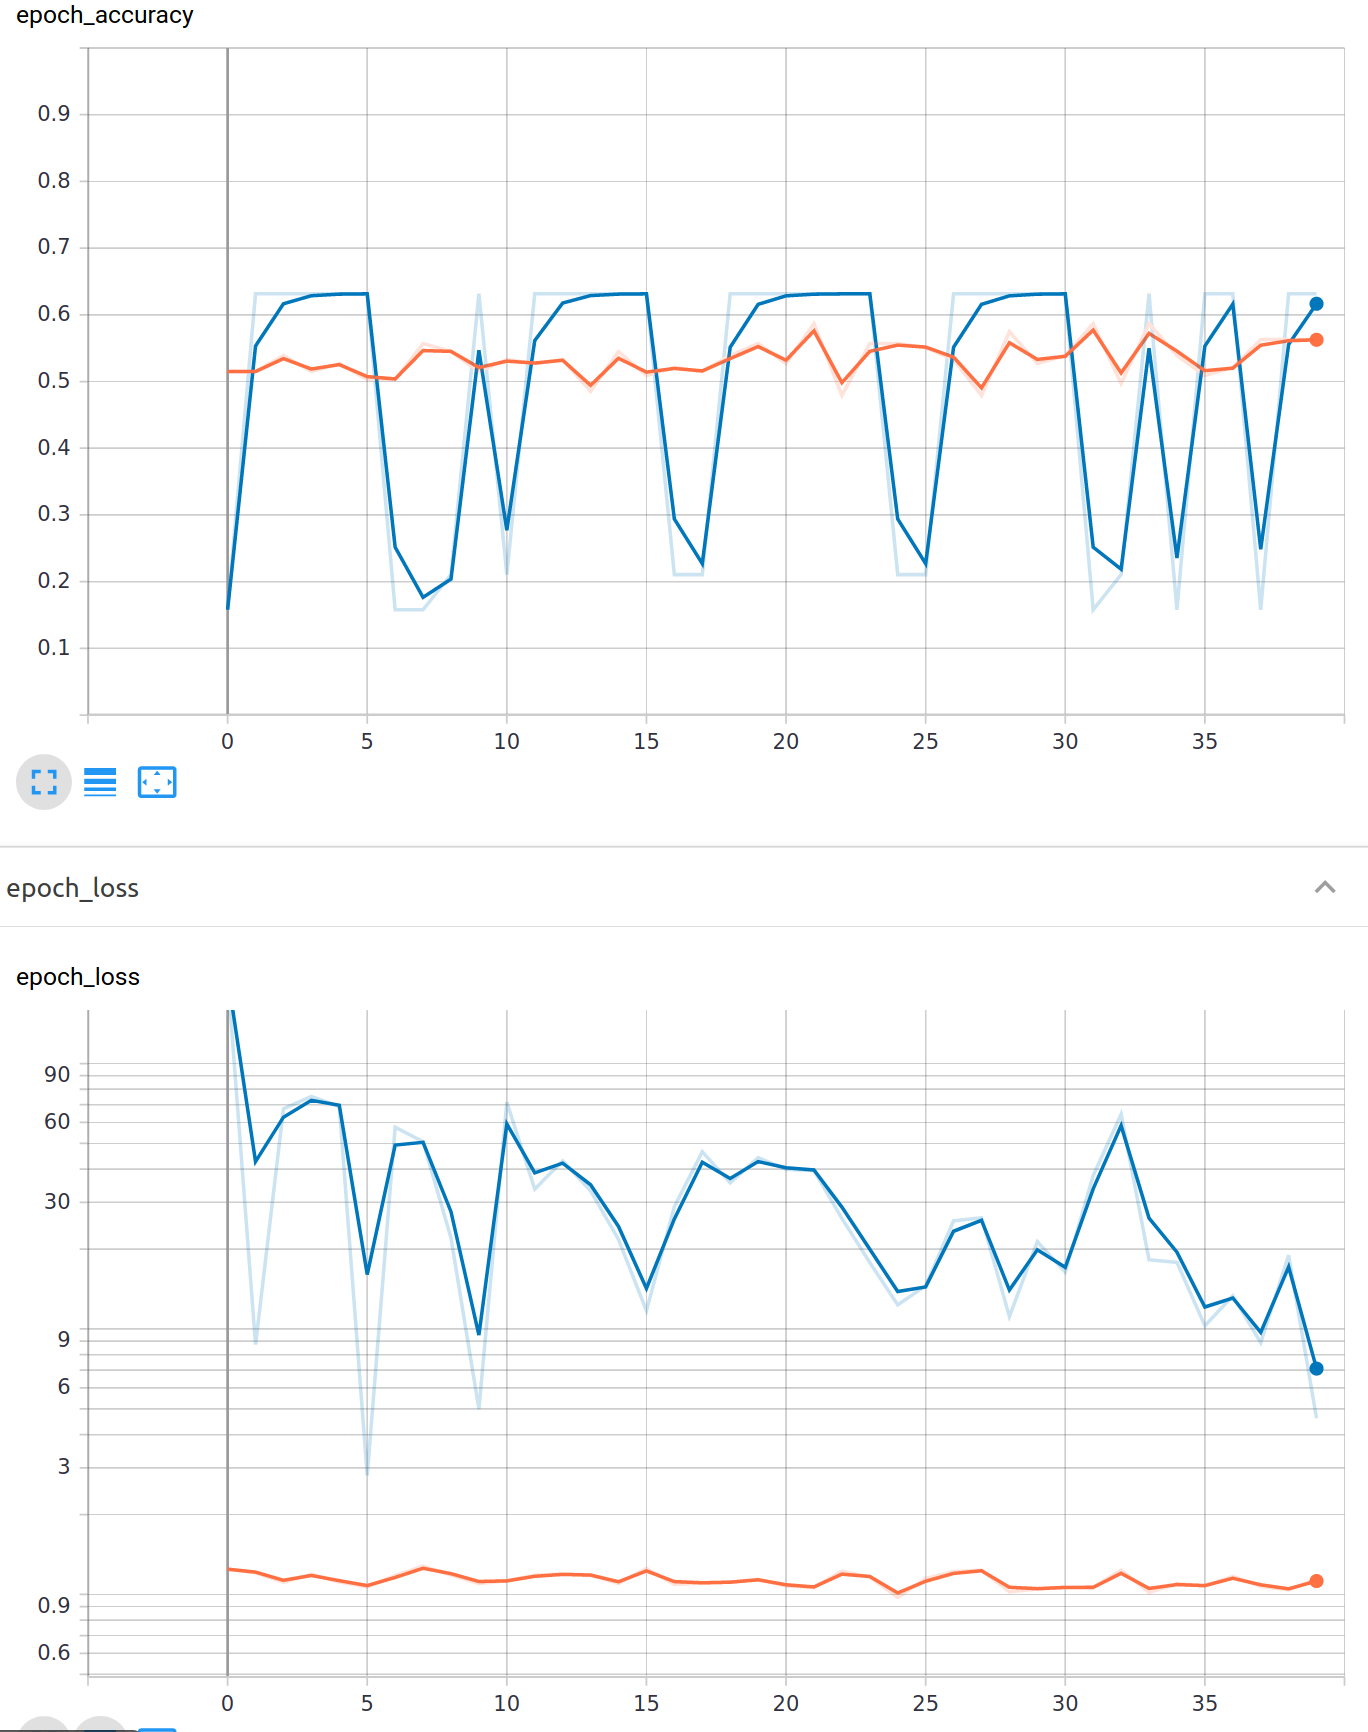</div>

In [131]:
# ECGNet 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# L2 normalization of signal_val (fit on train set)
# Window slicing on *10* seconds (2560 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
21/21 [==============================] - 2s 108ms/step - loss: 1.2448 - accuracy: 0.5150 - val_loss: 214.3405 - val_accuracy: 0.1579
Epoch 2/40
21/21 [==============================] - 2s 105ms/step - loss: 1.2071 - accuracy: 0.5150 - val_loss: 8.7350 - val_accuracy: 0.6316
Epoch 3/40
21/21 [==============================] - 2s 105ms/step - loss: 1.1107 - accuracy: 0.5389 - val_loss: 67.5513 - val_accuracy: 0.6316
Epoch 4/40
21/21 [==============================] - 2s 105ms/step - loss: 1.1905 - accuracy: 0.5150 - val_loss: 75.1525 - val_accuracy: 0.6316
Epoch 5/40
21/21 [==============================] - 2s 105ms/step - loss: 1.1137 - accuracy: 0.5269 - val_loss: 68.8429 - val_accuracy: 0.6316
Epoch 6/40
21/21 [==============================] - 2s 107ms/step - loss: 1.0682 - accuracy: 0.5030 - val_loss: 2.8085 - val_accuracy: 0.6316
Epoch 7/40
21/21 [==============================] - 2s 104ms/step - loss: 1.1779 - accuracy: 0.5030 - val_loss: 57.5350 - val_accuracy: 0.1579


In [44]:
# ECGNet 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# Max normalization of signal_val (fit on train set)
# Window slicing on *10* seconds (2560 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
21/21 [==============================] - 4s 178ms/step - loss: 1.2682 - accuracy: 0.4850 - val_loss: 690.4913 - val_accuracy: 0.6316
Epoch 2/40
21/21 [==============================] - 2s 100ms/step - loss: 1.3950 - accuracy: 0.4790 - val_loss: 137.0428 - val_accuracy: 0.6316
Epoch 3/40
21/21 [==============================] - 2s 99ms/step - loss: 1.3193 - accuracy: 0.4970 - val_loss: 9.5165 - val_accuracy: 0.6316
Epoch 4/40
21/21 [==============================] - 2s 102ms/step - loss: 1.0369 - accuracy: 0.5449 - val_loss: 3.1595 - val_accuracy: 0.6316
Epoch 5/40
21/21 [==============================] - 2s 101ms/step - loss: 1.2157 - accuracy: 0.4970 - val_loss: 6.5766 - val_accuracy: 0.2105
Epoch 6/40
21/21 [==============================] - 2s 99ms/step - loss: 1.4090 - accuracy: 0.4850 - val_loss: 1.8310 - val_accuracy: 0.6316
Epoch 7/40
21/21 [==============================] - 2s 100ms/step - loss: 1.0363 - accuracy: 0.6168 - val_loss: 1.6617 - val_accuracy: 0.2105
Epoc

### No LSTM layer; different normalizations - 10s non-overlap (2560); test_usr=3

In [20]:
# ECGNet (NO LSTM) 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# *No normalization* of signal_val (fit on train set)
# Window slicing on *10* seconds (2560 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
21/21 [==============================] - 72s 3s/step - loss: 1.1595 - accuracy: 0.5269 - val_loss: 5359.9551 - val_accuracy: 0.1579
Epoch 2/40
21/21 [==============================] - 1s 67ms/step - loss: 1.1028 - accuracy: 0.5689 - val_loss: 241.2967 - val_accuracy: 0.6316
Epoch 3/40
21/21 [==============================] - 2s 73ms/step - loss: 1.0972 - accuracy: 0.5569 - val_loss: 43.9189 - val_accuracy: 0.2105
Epoch 4/40
21/21 [==============================] - 1s 67ms/step - loss: 1.1578 - accuracy: 0.6108 - val_loss: 15.4640 - val_accuracy: 0.2105
Epoch 5/40
21/21 [==============================] - 1s 67ms/step - loss: 1.2929 - accuracy: 0.5449 - val_loss: 18.4707 - val_accuracy: 0.6316
Epoch 6/40
21/21 [==============================] - 1s 67ms/step - loss: 1.1107 - accuracy: 0.5988 - val_loss: 12.8278 - val_accuracy: 0.6316
Epoch 7/40
21/21 [==============================] - 1s 67ms/step - loss: 0.9548 - accuracy: 0.5868 - val_loss: 4.1839 - val_accuracy: 0.6316
Epoch

In [63]:
# ECGNet (NO LSTM) 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# *L2 normalization* of signal_val (fit on train set)
# Window slicing on *10* seconds (2560 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
21/21 [==============================] - 3s 136ms/step - loss: 1.3802 - accuracy: 0.4072 - val_loss: 6028.6421 - val_accuracy: 0.2105
Epoch 2/40
21/21 [==============================] - 1s 66ms/step - loss: 1.3055 - accuracy: 0.4671 - val_loss: 767.2759 - val_accuracy: 0.2105
Epoch 3/40
21/21 [==============================] - 1s 64ms/step - loss: 1.1069 - accuracy: 0.5449 - val_loss: 1416.7029 - val_accuracy: 0.2105
Epoch 4/40
21/21 [==============================] - 1s 63ms/step - loss: 1.1290 - accuracy: 0.5629 - val_loss: 639.4041 - val_accuracy: 0.6316
Epoch 5/40
21/21 [==============================] - 1s 65ms/step - loss: 1.2280 - accuracy: 0.5090 - val_loss: 316.2968 - val_accuracy: 0.2105
Epoch 6/40
21/21 [==============================] - 1s 65ms/step - loss: 1.4406 - accuracy: 0.4731 - val_loss: 510.5100 - val_accuracy: 0.6316
Epoch 7/40
21/21 [==============================] - 1s 65ms/step - loss: 1.2002 - accuracy: 0.4910 - val_loss: 363.7682 - val_accuracy: 0.6

In [89]:
# ECGNet (NO LSTM) 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# *L1 normalization* of signal_val (fit on train set)
# Window slicing on *10* seconds (2560 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
21/21 [==============================] - 3s 124ms/step - loss: 1.2201 - accuracy: 0.4850 - val_loss: 667590.6875 - val_accuracy: 0.1579
Epoch 2/40
21/21 [==============================] - 1s 61ms/step - loss: 1.2923 - accuracy: 0.5150 - val_loss: 63859.3242 - val_accuracy: 0.6316
Epoch 3/40
21/21 [==============================] - 1s 63ms/step - loss: 1.2746 - accuracy: 0.4671 - val_loss: 22498.0762 - val_accuracy: 0.6316
Epoch 4/40
21/21 [==============================] - 1s 62ms/step - loss: 1.3243 - accuracy: 0.5449 - val_loss: 4946.7476 - val_accuracy: 0.6316
Epoch 5/40
21/21 [==============================] - 1s 62ms/step - loss: 1.1834 - accuracy: 0.4970 - val_loss: 2379.2734 - val_accuracy: 0.6316
Epoch 6/40
21/21 [==============================] - 1s 62ms/step - loss: 1.4049 - accuracy: 0.4850 - val_loss: 2370.9512 - val_accuracy: 0.6316
Epoch 7/40
21/21 [==============================] - 1s 62ms/step - loss: 1.1743 - accuracy: 0.5210 - val_loss: 876.3365 - val_accur

In [77]:
# ECGNet (NO LSTM) 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# *Max normalization* of signal_val (fit on train set)
# Window slicing on *10* seconds (2560 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
21/21 [==============================] - 3s 132ms/step - loss: 1.2042 - accuracy: 0.5150 - val_loss: 12412.4883 - val_accuracy: 0.6316
Epoch 2/40
21/21 [==============================] - 1s 65ms/step - loss: 1.1335 - accuracy: 0.5749 - val_loss: 248.3369 - val_accuracy: 0.6316
Epoch 3/40
21/21 [==============================] - 1s 65ms/step - loss: 1.1640 - accuracy: 0.5329 - val_loss: 30.9251 - val_accuracy: 0.6316
Epoch 4/40
21/21 [==============================] - 1s 65ms/step - loss: 1.1071 - accuracy: 0.5569 - val_loss: 3.4521 - val_accuracy: 0.6316
Epoch 5/40
21/21 [==============================] - 1s 65ms/step - loss: 1.1298 - accuracy: 0.5569 - val_loss: 1.7598 - val_accuracy: 0.6316
Epoch 6/40
21/21 [==============================] - 1s 64ms/step - loss: 1.0326 - accuracy: 0.5808 - val_loss: 2.6398 - val_accuracy: 0.6316
Epoch 7/40
21/21 [==============================] - 1s 64ms/step - loss: 0.9923 - accuracy: 0.5569 - val_loss: 1.2377 - val_accuracy: 0.6316
Epoch

### 2.81s non-overlap (720); test_usr=3, no LSTM

In [24]:
# ECGNet (NO LSTM) 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# *No normalization* of signal_val (fit on train set)
# Window slicing on *2.81* seconds (720 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
75/75 [==============================] - 61s 814ms/step - loss: 1.2576 - accuracy: 0.5092 - val_loss: 26.8728 - val_accuracy: 0.6269
Epoch 2/40
75/75 [==============================] - 2s 32ms/step - loss: 1.1386 - accuracy: 0.5210 - val_loss: 1.4027 - val_accuracy: 0.6269
Epoch 3/40
75/75 [==============================] - 2s 33ms/step - loss: 1.0828 - accuracy: 0.5613 - val_loss: 2.3645 - val_accuracy: 0.6269
Epoch 4/40
75/75 [==============================] - 2s 33ms/step - loss: 1.1705 - accuracy: 0.5328 - val_loss: 3.0990 - val_accuracy: 0.6269
Epoch 5/40
75/75 [==============================] - 2s 33ms/step - loss: 1.0883 - accuracy: 0.5445 - val_loss: 1.2827 - val_accuracy: 0.6269
Epoch 6/40
75/75 [==============================] - 2s 33ms/step - loss: 1.0507 - accuracy: 0.5714 - val_loss: 1.1716 - val_accuracy: 0.6269
Epoch 7/40
75/75 [==============================] - 2s 33ms/step - loss: 1.0335 - accuracy: 0.5731 - val_loss: 2.4831 - val_accuracy: 0.6269
Epoch 8/40

In [38]:
# ECGNet (NO LSTM) 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# *L2 normalization* of signal_val (fit on train set)
# Window slicing on *10* seconds (2560 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
75/75 [==============================] - 4s 51ms/step - loss: 1.4141 - accuracy: 0.4639 - val_loss: 146.0750 - val_accuracy: 0.6269
Epoch 2/40
75/75 [==============================] - 2s 32ms/step - loss: 1.2676 - accuracy: 0.5092 - val_loss: 111.9062 - val_accuracy: 0.6269
Epoch 3/40
75/75 [==============================] - 3s 35ms/step - loss: 1.1722 - accuracy: 0.5042 - val_loss: 18.3077 - val_accuracy: 0.2239
Epoch 4/40
75/75 [==============================] - 3s 35ms/step - loss: 1.1718 - accuracy: 0.5092 - val_loss: 30.0123 - val_accuracy: 0.6269
Epoch 5/40
75/75 [==============================] - 3s 34ms/step - loss: 1.1408 - accuracy: 0.4975 - val_loss: 21.8218 - val_accuracy: 0.2239
Epoch 6/40
75/75 [==============================] - 3s 34ms/step - loss: 1.1102 - accuracy: 0.5513 - val_loss: 51.8727 - val_accuracy: 0.6269
Epoch 7/40
75/75 [==============================] - 3s 34ms/step - loss: 1.1138 - accuracy: 0.5361 - val_loss: 2.8054 - val_accuracy: 0.6269
Epoch

### 2.81s non-overlap (720); test_usr=3, with LSTM, no norm

In [57]:
# ECGNet 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# No normalization of signal_val (fit on train set)
# Window slicing on *2.81* seconds (720 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
75/75 [==============================] - 5s 66ms/step - loss: 1.1189 - accuracy: 0.5277 - val_loss: 16.7991 - val_accuracy: 0.3582
Epoch 2/40
75/75 [==============================] - 3s 45ms/step - loss: 1.2078 - accuracy: 0.5479 - val_loss: 2.9521 - val_accuracy: 0.6269
Epoch 3/40
75/75 [==============================] - 3s 45ms/step - loss: 1.1168 - accuracy: 0.5361 - val_loss: 1.4885 - val_accuracy: 0.6269
Epoch 4/40
75/75 [==============================] - 4s 49ms/step - loss: 1.1046 - accuracy: 0.5546 - val_loss: 2.2939 - val_accuracy: 0.6269
Epoch 5/40
75/75 [==============================] - 3s 45ms/step - loss: 1.1300 - accuracy: 0.5429 - val_loss: 4.2353 - val_accuracy: 0.2239
Epoch 6/40
75/75 [==============================] - 3s 46ms/step - loss: 1.1267 - accuracy: 0.5143 - val_loss: 1.0908 - val_accuracy: 0.2239
Epoch 7/40
75/75 [==============================] - 3s 46ms/step - loss: 0.9884 - accuracy: 0.5714 - val_loss: 1.2804 - val_accuracy: 0.6119
Epoch 8/40
7

### 5s non-overlap (1280); test_usr=3, with & without LSTM, no norm

In [24]:
# ECGNet 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# 
# Max normalization of signal_val (fit on train set)
# Window slicing on *5* seconds (1280 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
42/42 [==============================] - 80s 2s/step - loss: 1.2989 - accuracy: 0.4671 - val_loss: 162.4567 - val_accuracy: 0.6316
Epoch 2/40
42/42 [==============================] - 2s 59ms/step - loss: 1.3492 - accuracy: 0.5000 - val_loss: 3.6510 - val_accuracy: 0.5000
Epoch 3/40
42/42 [==============================] - 2s 59ms/step - loss: 1.0738 - accuracy: 0.5749 - val_loss: 1.4128 - val_accuracy: 0.6053
Epoch 4/40
42/42 [==============================] - 3s 60ms/step - loss: 1.0829 - accuracy: 0.5599 - val_loss: 1.8432 - val_accuracy: 0.2105
Epoch 5/40
42/42 [==============================] - 3s 61ms/step - loss: 1.1637 - accuracy: 0.5359 - val_loss: 1.1378 - val_accuracy: 0.2632
Epoch 6/40
42/42 [==============================] - 3s 60ms/step - loss: 1.0636 - accuracy: 0.5509 - val_loss: 0.9958 - val_accuracy: 0.6316
Epoch 7/40
42/42 [==============================] - 2s 59ms/step - loss: 1.0657 - accuracy: 0.5240 - val_loss: 1.1460 - val_accuracy: 0.5526
Epoch 8/40
4

In [27]:
# ECGNet 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# NO LSTM
# Max normalization of signal_val (fit on train set)
# Window slicing on *5* seconds (1280 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
42/42 [==============================] - 3s 80ms/step - loss: 1.2051 - accuracy: 0.5120 - val_loss: 47.6703 - val_accuracy: 0.6316
Epoch 2/40
42/42 [==============================] - 2s 40ms/step - loss: 1.2560 - accuracy: 0.5479 - val_loss: 1.5550 - val_accuracy: 0.2632
Epoch 3/40
42/42 [==============================] - 2s 41ms/step - loss: 1.3166 - accuracy: 0.5599 - val_loss: 1.0302 - val_accuracy: 0.6053
Epoch 4/40
42/42 [==============================] - 2s 41ms/step - loss: 1.2983 - accuracy: 0.5509 - val_loss: 1.4085 - val_accuracy: 0.5789
Epoch 5/40
42/42 [==============================] - 2s 42ms/step - loss: 1.1613 - accuracy: 0.5509 - val_loss: 3.2329 - val_accuracy: 0.2105
Epoch 6/40
42/42 [==============================] - 2s 43ms/step - loss: 1.2717 - accuracy: 0.5060 - val_loss: 1.3459 - val_accuracy: 0.2368
Epoch 7/40
42/42 [==============================] - 2s 42ms/step - loss: 0.9989 - accuracy: 0.5778 - val_loss: 1.1514 - val_accuracy: 0.6316
Epoch 8/40
4

In [69]:
# ECGNet 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# NO LSTM
#  ---- LOSO VALIDATION ----
# Max normalization of signal_val (fit on train set)
# Window slicing on *5* seconds (1280 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])

Epoch 1/40
47/47 [==============================] - 96s 2s/step - loss: 1.2119 - accuracy: 0.4973 - val_loss: 84.3227 - val_accuracy: 0.6000
Epoch 2/40
47/47 [==============================] - 2s 41ms/step - loss: 1.3448 - accuracy: 0.5161 - val_loss: 6.5390 - val_accuracy: 0.6000
Epoch 3/40
47/47 [==============================] - 2s 41ms/step - loss: 1.1649 - accuracy: 0.5376 - val_loss: 78.3915 - val_accuracy: 0.6000
Epoch 4/40
47/47 [==============================] - 2s 41ms/step - loss: 1.2184 - accuracy: 0.5484 - val_loss: 38.1466 - val_accuracy: 0.6000
Epoch 5/40
47/47 [==============================] - 2s 41ms/step - loss: 1.4131 - accuracy: 0.4892 - val_loss: 62.8210 - val_accuracy: 0.6000
Epoch 6/40
47/47 [==============================] - 2s 42ms/step - loss: 1.1331 - accuracy: 0.5242 - val_loss: 9.5395 - val_accuracy: 0.6000
Epoch 7/40
47/47 [==============================] - 2s 41ms/step - loss: 1.2282 - accuracy: 0.5430 - val_loss: 5.0904 - val_accuracy: 0.6000
Epoch 8/40

### Ensemble ECGNet w/o LSTM, 5s non-overlap (1280), all test_usr

### No test_usr, training on all data

In [39]:
# ECGNet 40 epoch run, 10% val set, 0.01 LR, 0.9 momentum, 8 batch size
# NO LSTM
#
# ALL TRAINING (NO LOSO SET)
#
# Max normalization of signal_val (fit on train set)
# Window slicing on *5* seconds (1280 samples per window)
# Output: 3 class one-hot encoded
#
train_hist = ecgnet.fit(x_train, y_train, batch_size=8, epochs=40, validation_split=0.1, callbacks=[tensorboard_callback])

Epoch 1/40
46/46 [==============================] - 75s 2s/step - loss: 1.1569 - accuracy: 0.5232 - val_loss: 69.0891 - val_accuracy: 0.6585
Epoch 2/40
46/46 [==============================] - 2s 40ms/step - loss: 1.1562 - accuracy: 0.5259 - val_loss: 4.5324 - val_accuracy: 0.1951
Epoch 3/40
46/46 [==============================] - 2s 40ms/step - loss: 1.2553 - accuracy: 0.5150 - val_loss: 1.6279 - val_accuracy: 0.2439
Epoch 4/40
46/46 [==============================] - 2s 40ms/step - loss: 1.1400 - accuracy: 0.5259 - val_loss: 0.9467 - val_accuracy: 0.5854
Epoch 5/40
46/46 [==============================] - 2s 40ms/step - loss: 1.1902 - accuracy: 0.5204 - val_loss: 1.5552 - val_accuracy: 0.1951
Epoch 6/40
46/46 [==============================] - 2s 40ms/step - loss: 1.0841 - accuracy: 0.5341 - val_loss: 1.0736 - val_accuracy: 0.6585
Epoch 7/40
46/46 [==============================] - 2s 40ms/step - loss: 1.0786 - accuracy: 0.5613 - val_loss: 4.6180 - val_accuracy: 0.1951
Epoch 8/40
46